In [159]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Keras imports
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout, Flatten, MaxPooling2D, Activation, LeakyReLU

In [160]:
# starting work on mnist branch.splitting the data into train/test. x = images, y = class 0-9;
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


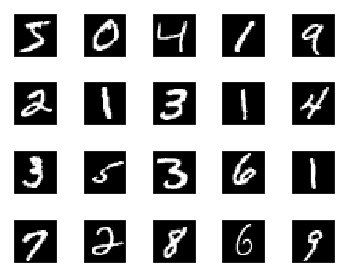

mnist shape
(60000, 28, 28)
mnist shape: first dim
60000
mnist shape: second dim
28


In [161]:
# display a sample of the mnist data
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

print('mnist shape')
print(x_train.shape)
print('mnist shape: first dim')
print(x_train.shape[0])
print('mnist shape: second dim')
print(x_train.shape[1])

In [162]:
# reshaping the mnist data -> [# of images, img_height, img_width, img_depth (=1 b/c 1 bit -> 2 colors (black or white))]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

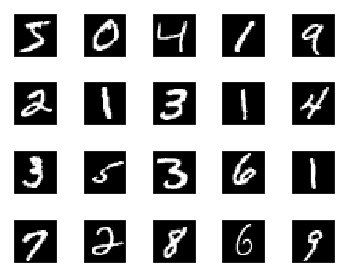

In [163]:
# check that reshaping worked

plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    img = x_train[i][0:28]
    img = img.reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [164]:
# converting type to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the rgb codes
x_train = x_train/255
x_test = x_test/255

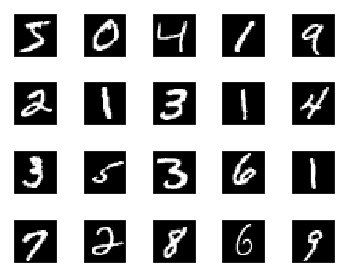

In [165]:
# check normalized images still work

plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    img = x_train[i][0:28]
    img = img.reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [166]:
# Input noise to generator
def sample_Z(batch_size, m, n):
    return np.random.uniform(0, 1, size=[batch_size, m, n, 1])


In [174]:
# Generator function
def generator(Z, reuse=False):
    # create a sequential model
    model = Sequential()
    
    # adding layers - 2 leaky relu and 1 tanh
    model.add(Dense(128, input_shape=(256,28,28)))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(Dense(128))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(Dense(784))
    model.add(Activation('tanh'))
    
    # print the structure of the model
    print(model.summary())
    
    # output of the model
    return model

Z = sample_Z(256,28,28)

G = generator(Z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 256, 28, 128)      3712      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 256, 28, 128)      0         
_________________________________________________________________
dense_44 (Dense)             (None, 256, 28, 128)      16512     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 256, 28, 128)      0         
_________________________________________________________________
dense_45 (Dense)             (None, 256, 28, 784)      101136    
_________________________________________________________________
activation_7 (Activation)    (None, 256, 28, 784)      0         
Total params: 121,360
Trainable params: 121,360
Non-trainable params: 0
_________________________________________________________________
None

In [ ]:
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3


# def discriminator(X,hsize=[16, 16],reuse=False):
#     with tf.variable_scope("GAN/Discriminator",reuse=reuse):
#         h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
#         h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
#         h3 = tf.layers.dense(h2,2)
#         out = tf.layers.dense(h3,1)
#
#     return out, h3

In [ ]:
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

In [ ]:
# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    
    # 28 x 28 pixel images
    Z_batch = sample_Z(batch_size, 28, 28)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f" % (i,dloss,gloss))
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i%1000 == 0:
        # Iterations gif
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])
        plt.xlim(-60, 60)
        plt.ylim(-50, 2600)
        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../plots/iterations/iteration_%d.png'%i)
        plt.close()

        # Feature transform gif
        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)
        plt.xlim(-200, 200)
        plt.ylim(-40, 40)
        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../plots/features/feature_transform_%d.png'%i)
        plt.close()

        # Feature transform of centroids gif
        plt.figure()
        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)
        plt.xlim(-50, 50)
        plt.ylim(-50, 50)
        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../plots/features/feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()